## prepare for modeling and create baseline model

In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from utils import preprocess_data, validate_data, predict_psp_probabilities, evaluate_model, preprocess_and_train_model, log_transform 
from setup_model_eval_log import log_model_evaluation

data_location = '../data/raw/psp_raw_data.xlsx'

### retrieve, preprocess and validate data
- feature selection based in previous analysis

In [2]:
df = pd.read_excel(data_location, index_col=0)

# Apply the preprocessing and validation function
df = preprocess_data(df)
print(validate_data(df))
display(df.head())
df.to_csv('../data/processed/baseline_data.csv', index=False)

Validation complete and successful.
None


,country,card,3d_secured,is_peak_time,amount,psp,success
0,Germany,Visa,0,0,89,UK_Card,0
1,Germany,Visa,0,0,89,UK_Card,1
2,Germany,Diners,1,0,238,UK_Card,0
3,Germany,Diners,1,0,238,UK_Card,1
4,Austria,Diners,0,0,124,Simplecard,0


## baseline model 
- no handling imbalance, no hyperparameter tuning, etc

### create model

In [3]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured', 'is_peak_time'] # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([ # positively skewed -- log and then scale
            ('log', FunctionTransformer(log_transform, validate=True)), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features), # nominal
        ('binary', 'passthrough', binary_features)
    ]
)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

Validation complete and successful.
None


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_and_scale',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x146c3d1c0>,
                                                                                       validate=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['amount']),
                                                 ('cat', OneHotEncoder(),
                                                  ['country', 'card', 'psp']),
                                                 ('binary', 'passthrough',
                                                  ['3d_secured',
                                                   'is_peak_time'])])),
                ('classifier',
                 XGBCl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### use model

In [4]:
# Simulate a larger dataset with 10 new data points
np.random.seed(42)  # For reproducibility

# Generate random data
countries = ['Germany', 'Switzerland', 'Austria']
cards = ['Visa', 'Master', 'Diners']
amounts = np.random.randint(10, 1000, size=10)  # Random amounts between 10 and 1000
secure_flags = np.random.randint(0, 2, size=10)  # Random 0 or 1 for '3d_secured'
peak_time_flags = np.random.randint(0, 2, size=10)  # Random 0 or 1 for 'is_peak_time'

# Create the new data DataFrame
new_data = pd.DataFrame({
    'country': np.random.choice(countries, size=10),
    'card': np.random.choice(cards, size=10),
    'amount': amounts,
    '3d_secured': secure_flags,
    'is_peak_time': peak_time_flags
})

# Get all unique PSPs
psp_list = df['psp'].unique()

# Predict probabilities
probabilities = predict_psp_probabilities(
    model=pipeline.named_steps['classifier'], 
    preprocessor=pipeline.named_steps['preprocessor'], 
    new_transactions=new_data, 
    psp_list=psp_list
)

# Create a DataFrame for the input features
input_data_df = new_data.reset_index(drop=True)

# Convert the probabilities into a DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=psp_list).round(2)
probabilities_df.columns = [f'{col} %' for col in probabilities_df.columns]

# Concatenate the probabilities to the input data
final_df = pd.concat([input_data_df, probabilities_df], axis=1)

# Output the final DataFrame
print("Predicted probabilities for each PSP:")
display(final_df)


Predicted probabilities for each PSP:


,country,card,amount,3d_secured,is_peak_time,UK_Card %,Simplecard %,Moneycard %,Goldcard %
0,Germany,Master,112,0,1,0.34,0.09,0.60,0.48
1,Germany,Diners,445,0,0,0.13,0.50,0.34,0.73
2,Switzerland,Master,870,0,1,0.01,0.06,0.21,0.17
3,Switzerland,Master,280,0,1,0.11,0.09,0.22,0.53
4,Germany,Diners,116,1,1,0.28,0.33,0.29,0.58
5,Germany,Master,81,0,1,0.29,0.23,0.42,0.39
6,Germany,Diners,710,1,1,0.11,0.82,0.55,0.92
7,Austria,Diners,30,1,1,0.12,0.40,0.32,0.66
8,Austria,Visa,624,1,1,0.03,0.16,0.14,0.38
9,Austria,Diners,131,0,1,0.21,0.24,0.52,0.46


### evaluate model

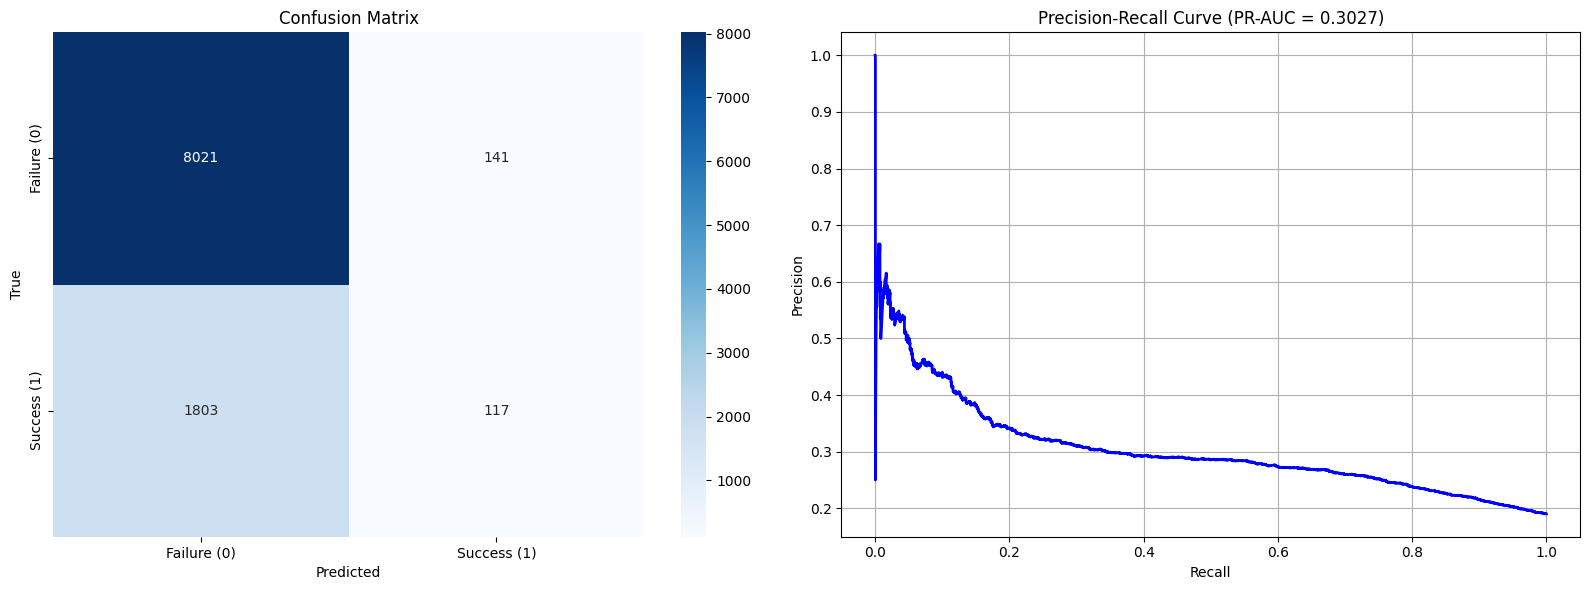


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.816470,0.982725,0.891916,8162.000000
Success (1),0.453488,0.060937,0.107438,1920.000000
accuracy,0.807181,0.807181,0.807181,0.807181
macro avg,0.634979,0.521831,0.499677,10082.000000
weighted avg,0.747344,0.807181,0.742521,10082.000000


Best F1-Score: 0.3835 at Threshold: 0.1875
Total Model F1-Score: 0.1074
Total Model Precision: 0.4535


In [5]:
evaluate_model(pipeline, X_test, y_test)

## compare different classifiers 


Evaluating RandomForestClassifier
Validation complete and successful.
None


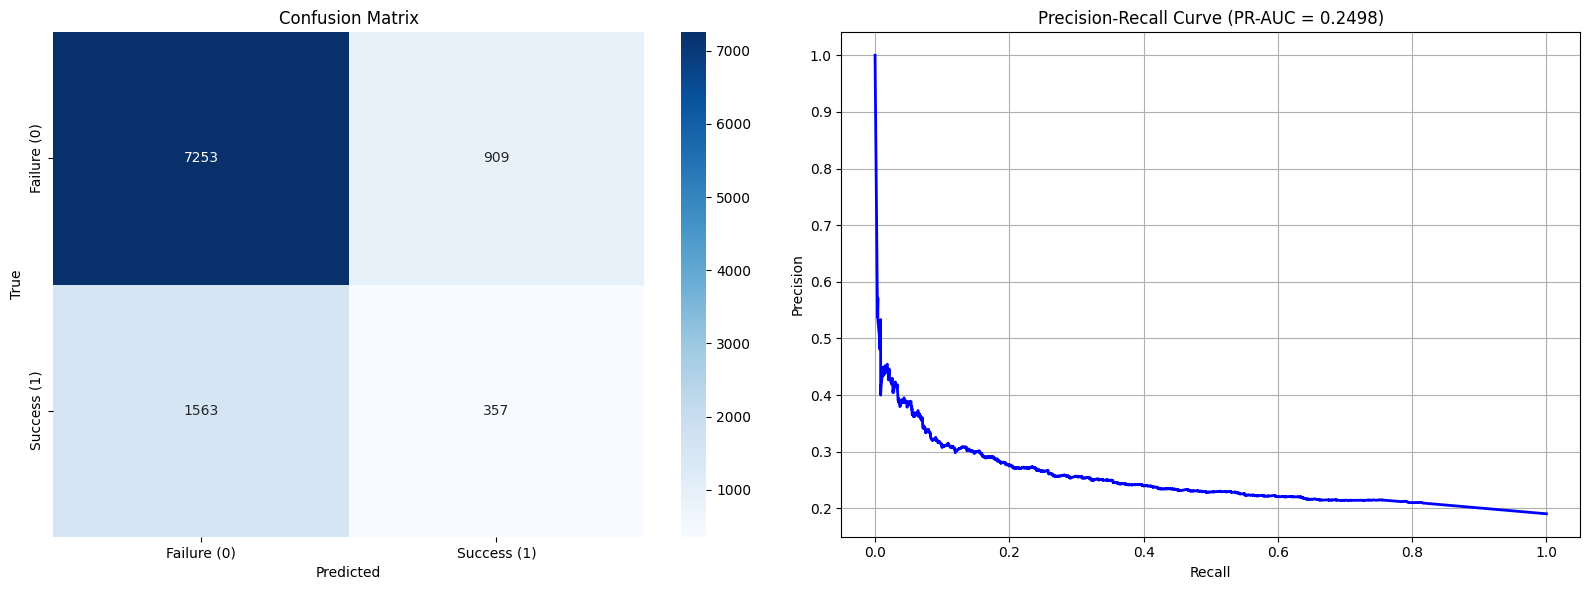


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.822709,0.888630,0.854400,8162.000000
Success (1),0.281991,0.185938,0.224105,1920.000000
accuracy,0.754811,0.754811,0.754811,0.754811
macro avg,0.552350,0.537284,0.539253,10082.000000
weighted avg,0.719735,0.754811,0.734368,10082.000000


Best F1-Score: 0.3351 at Threshold: 0.0083
Total Model F1-Score: 0.2241
Total Model Precision: 0.2820

Evaluating LogisticRegression
Validation complete and successful.
None


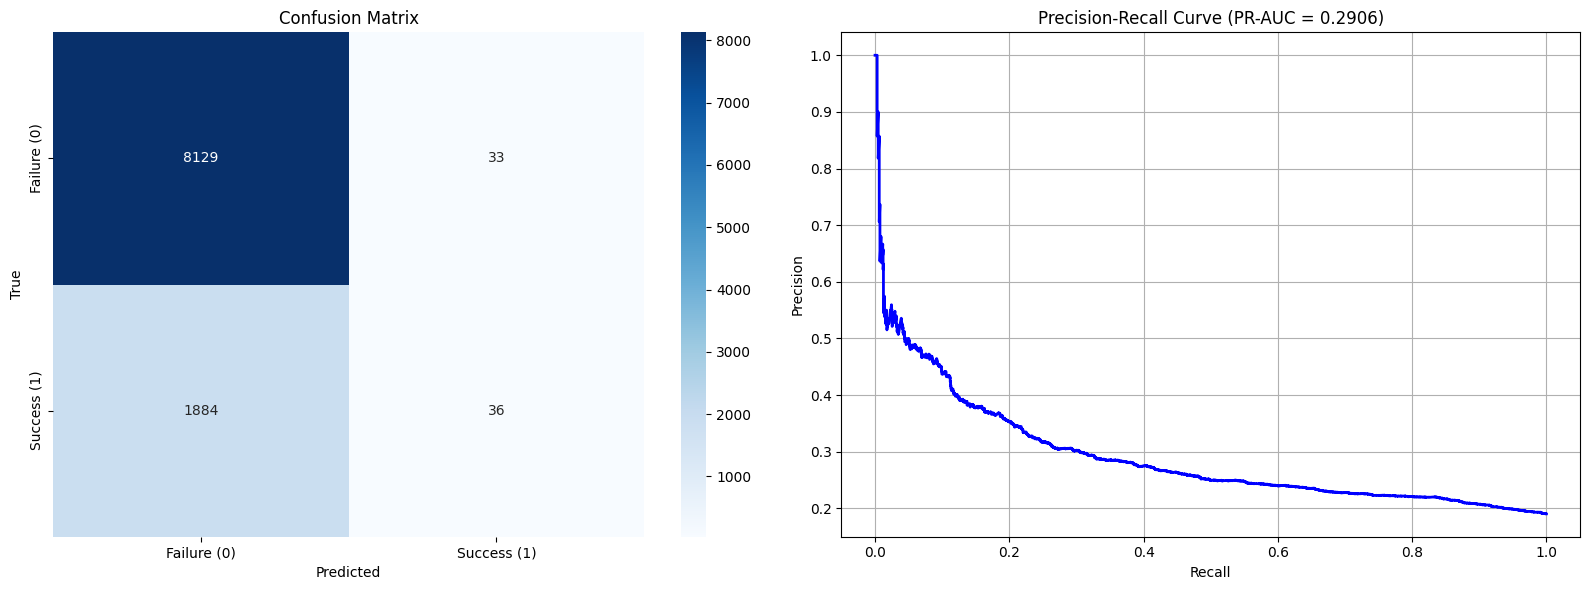


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.811845,0.995957,0.894525,8162.000000
Success (1),0.521739,0.018750,0.036199,1920.000000
accuracy,0.809859,0.809859,0.809859,0.809859
macro avg,0.666792,0.507353,0.465362,10082.000000
weighted avg,0.756597,0.809859,0.731067,10082.000000


Best F1-Score: 0.3486 at Threshold: 0.1626
Total Model F1-Score: 0.0362
Total Model Precision: 0.5217

Evaluating XGBoost
Validation complete and successful.
None


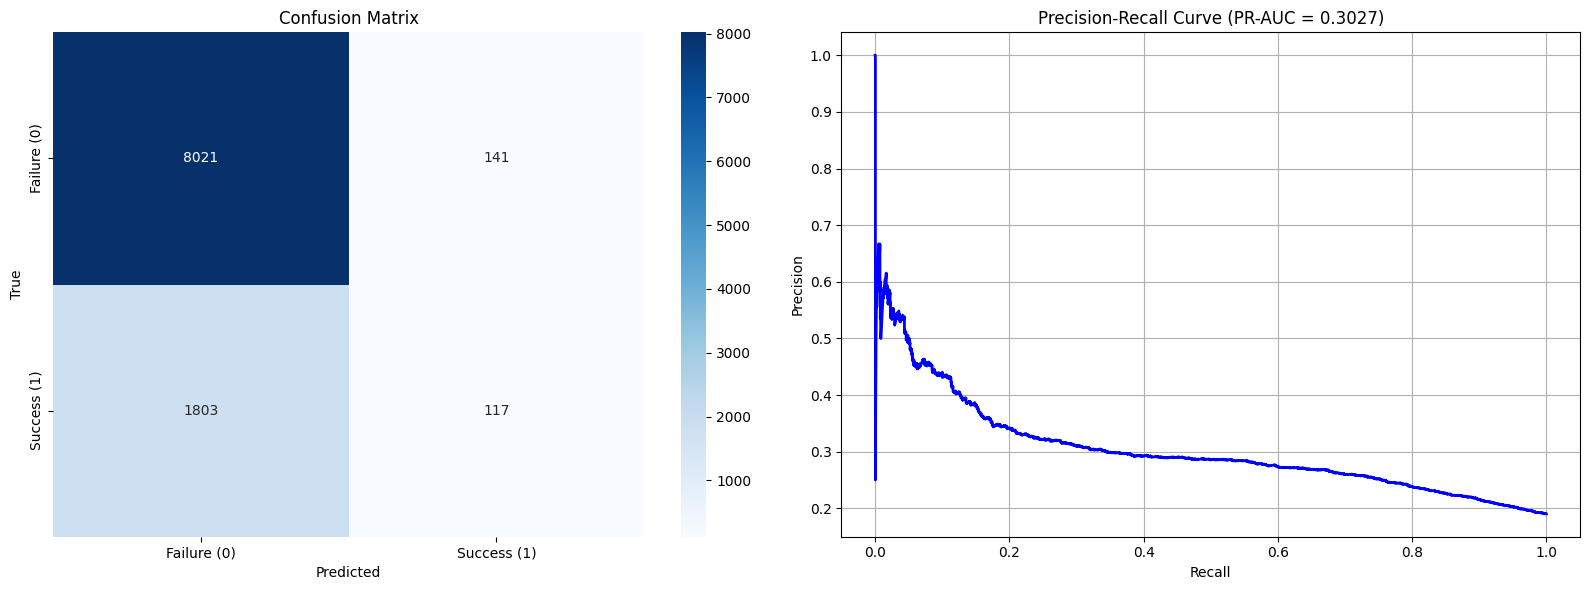


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.816470,0.982725,0.891916,8162.000000
Success (1),0.453488,0.060937,0.107438,1920.000000
accuracy,0.807181,0.807181,0.807181,0.807181
macro avg,0.634979,0.521831,0.499677,10082.000000
weighted avg,0.747344,0.807181,0.742521,10082.000000


Best F1-Score: 0.3835 at Threshold: 0.1875
Total Model F1-Score: 0.1074
Total Model Precision: 0.4535


In [6]:
# For RandomForest
print("\nEvaluating RandomForestClassifier")
pipeline_rf, X_test_rf, y_test_rf, _ = preprocess_and_train_model(data_location, model_type='random_forest')

# Make predictions for RandomForest
y_test_pred_rf = pipeline_rf.predict(X_test_rf)
y_test_pred_prob_rf = pipeline_rf.predict_proba(X_test_rf)[:, 1]
evaluate_model(pipeline_rf, X_test_rf, y_test_rf)  # Pass pipeline_rf to evaluate_model

# For Logistic Regression
print("\nEvaluating LogisticRegression")
pipeline_lr, X_test_lr, y_test_lr, _ = preprocess_and_train_model(data_location, model_type='logistic_regression')

# Make predictions for Logistic Regression
y_test_pred_lr = pipeline_lr.predict(X_test_lr)
y_test_pred_prob_lr = pipeline_lr.predict_proba(X_test_lr)[:, 1]
evaluate_model(pipeline_lr, X_test_lr, y_test_lr)  # Pass pipeline_lr to evaluate_model

# For XGBoost
print("\nEvaluating XGBoost")
pipeline_xgb, X_test_xgb, y_test_xgb, feature_name_importance = preprocess_and_train_model(data_location, model_type='xgboost')

# Make predictions for XGBoost
y_test_pred_xgb = pipeline_xgb.predict(X_test_xgb)
y_test_pred_prob_xgb = pipeline_xgb.predict_proba(X_test_xgb)[:, 1]
evaluate_model(pipeline_xgb, X_test_xgb, y_test_xgb)  # Pass pipeline_xgb to evaluate_model

### Observations

#### Random Forest:
- **Success Class (1)** has a very low F1-score of **0.2235**.
- **Failure Class (0)** performs relatively better, with an F1-score of **0.8547**.
- The overall model F1-score is **0.2235**, which reflects the imbalance in the data.

#### Logistic Regression:
- **Failure Class (0)** performs excellently with an F1-score of **0.8945**.
- **Success Class (1)** has an extremely low F1-score of **0.0362**, which is concerning.
- The overall model has a much higher weighted F1-score of **0.7311**, but this is mainly driven by the high performance on the failure class.

#### XGBoost:
- Similar to Random Forest, **Failure Class (0)** performs better with an F1-score of **0.8919**.
- **Success Class (1)** has an F1-score of **0.1074**, which is very low.
- The overall model F1-score of **0.1074** for the success class suggests that the model struggles with this class.


### I will go with XGBoost:

1. **Better Handling of Imbalanced Data**:
   - XGBoost performs better with imbalanced datasets. While **Failure Class (0)** performs well across models, XGBoost can be fine-tuned to improve performance on **Success Class (1)**, which has a lower F1-score.

2. **Feature Importance and Interpretability**:
   - XGBoost provides clear feature importance metrics, which help identify the most influential features for predictions. This is more interpretable than other models like Random Forest or Logistic Regression.

3. **Flexibility in Hyperparameter Tuning**:
   - XGBoost allows for fine-grained control over hyperparameters (e.g., `learning_rate`, `max_depth`, `subsample`) that can help improve performance on both classes, especially with imbalanced data.

4. **Better Generalization**:
   - XGBoost is known for its strong generalization ability. It tends to perform better on unseen data compared to Logistic Regression and Random Forest, particularly with proper tuning.

5. **Efficiency and Scalability**:
   - XGBoost is faster and more scalable than Random Forest, making it suitable for larger datasets. It can handle a higher number of features efficiently, which is important when dealing with complex data.

6. **Performance Boost with Hyperparameter Tuning**:
   - Despite the low F1-score for **Success Class (1)**, XGBoost’s performance can be improved through techniques like class weight adjustment and hyperparameter optimization.

### Potential for Improvement:
- **Hyperparameter Tuning**: Fine-tuning hyperparameters (e.g., `scale_pos_weight`, `learning_rate`) can further boost the performance on the minority class.
-- **Class Weight Adjustment**: Adjusting the class weights in XGBoost can help balance the focus between both classes.
- **Resampling Techniques**: Combining XGBoost with methods like **SMOTE** can address the imbalance in the data and improve performance for **Success Class (1)**.

In [7]:
# Display the DataFrame with sorted feature importance scores
sorted_feature_importance_asc = {k: v for k, v in sorted(feature_name_importance.items(), key=lambda item: item[1], reverse=True)}
display(sorted_feature_importance_asc)

{'card_Master': 9.745332717895508,
 'card_Visa': 3.3172407150268555,
 'psp_Goldcard': 2.9010910987854004,
 'psp_Simplecard': 2.7719390392303467,
 'card_Diners': 2.138805389404297,
 'amount': 1.8361656665802002,
 'country_Germany': 1.819286584854126,
 'country_Switzerland': 1.7844820022583008,
 'psp_Moneycard': 1.585629940032959,
 'psp_UK_Card': 1.5457359552383423,
 '3d_secured': 1.2106208801269531,
 'country_Austria': 1.1750017404556274,
 'is_peak_time': 1.144468069076538}

## analyze is_peak_time
- the feature importance is very low and I had already suggested that this feature might not be very informative
- model without it to check importance

Validation complete and successful.
None


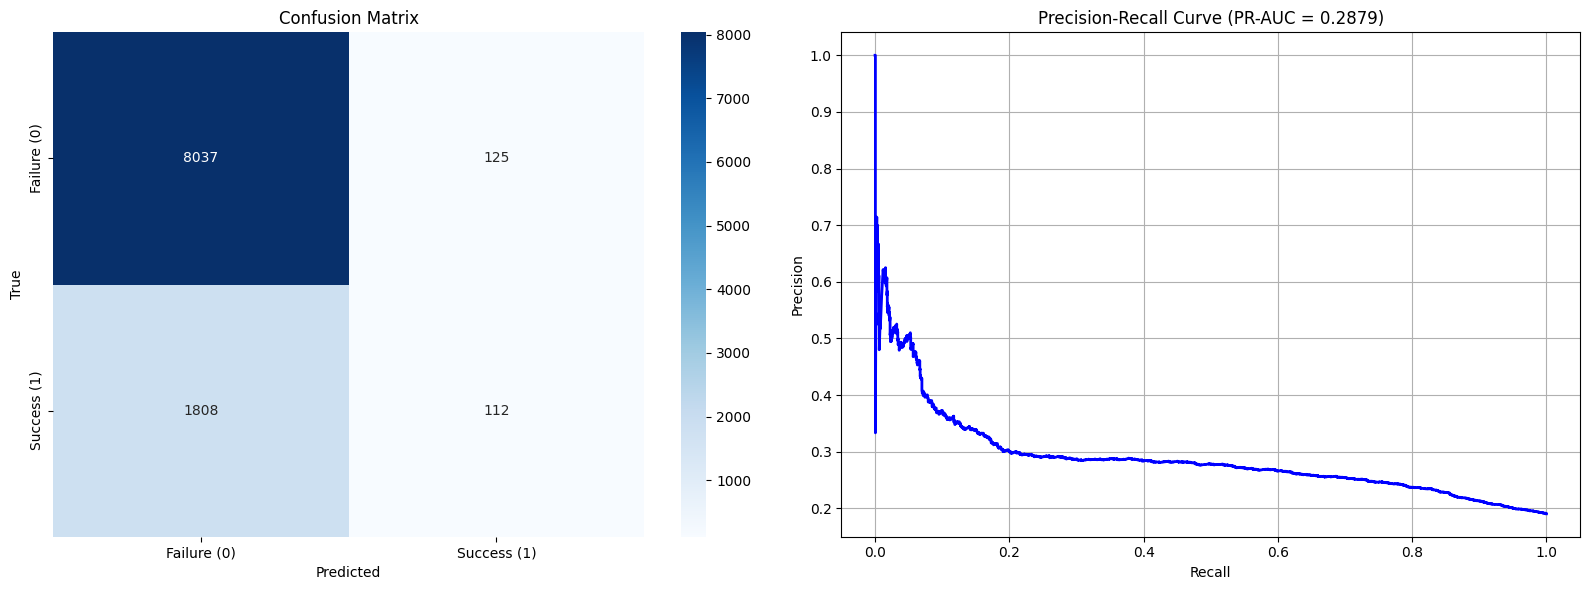


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.816353,0.984685,0.892653,8162.000000
Success (1),0.472574,0.058333,0.103848,1920.000000
accuracy,0.808272,0.808272,0.808272,0.808272
macro avg,0.644464,0.521509,0.498250,10082.000000
weighted avg,0.750885,0.808272,0.742434,10082.000000


Best F1-Score: 0.3738 at Threshold: 0.1808
Total Model F1-Score: 0.1038
Total Model Precision: 0.4726


In [8]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured'] # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success', 'is_peak_time'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([ # positively skewed -- log and then scale
            ('log', FunctionTransformer(log_transform, validate=True)), 
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features), # nominal
        ('binary', 'passthrough', binary_features)
    ]
)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)
evaluate_model(pipeline, X_test, y_test)

### Feature Importance: `is_peak_time`

- **With `is_peak_time`:**
  - Accuracy: 80.72%
  - F1-Score: 0.1074
  - Precision: 0.4535

- **Without `is_peak_time`:**
  - Accuracy: 80.83%
  - F1-Score: 0.1038
  - Precision: 0.4726

### Conclusion:
- Removing the `is_peak_time` feature led to a minor increase in accuracy and precision, but the overall model performance remains similar.
- The feature does not significantly improve the model, so it can be removed for simplicity and to reduce model complexity.

In [9]:
# pickle model 
with open('../models/xgboost_baseline_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)

to unpickle:

import pickle

with open('../models/xgboost_baseline_model.pkl', 'rb') as model_file:
    loaded_pipeline = pickle.load(model_file)


In [10]:
# Log the evaluation of the model
log_model_evaluation(
    model=pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="xgboost_baseline_model",
    notes="Baseline Model, Vanilla XGBoost."
)

In [11]:
eval = pd.read_csv("../models/evaluation/model_evaluation_log.csv")
eval

,Model_Name,Confusion_Matrix,PR_AUC,F1_Score_Overall,Precision_Overall,Recall_Overall,Class_Metrics,Train_Score,Validation_Score,Notes,Hyperparameters
0,xgboost_baseline_model,"[[8037, 125], [1808, 112]]",0.287947,0.103848,0.472574,0.058333,"{""Failure (0)"": {""precision"": 0.81635347892331...",0.805272,0.808272,"Baseline Model, Vanilla XGBoost.","{""memory"": ""None"", ""steps"": ""[('preprocessor',..."
